In [10]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt

from pprint import pprint
from sklearn.preprocessing import StandardScaler
# Set some display options for Pandas.
pd.set_option('display.max_colwidth', 100)
pd.set_option('expand_frame_repr', False)

In [11]:
# Load the CSV file into a DataFrame
price_data_frame = pd.read_csv('stock_data.csv')

# Rename all columns to lowercase
price_data_frame.columns = [col.lower() for col in price_data_frame.columns]

# Rename the 'ticker' column to 'symbol'
price_data_frame.rename(columns={'ticker': 'symbol'}, inplace=True)

# Filter the DataFrame to keep only the date, symbol, and adjusted close columns
price_data_frame = price_data_frame[['date', 'symbol', 'adj close']]

# Count the total number of unique symbols
number_of_symbols = price_data_frame['symbol'].nunique()

print("Total number of unique symbols:", number_of_symbols)


Total number of unique symbols: 4


In [12]:


# Once we've done that, use the `pivot` method to reorganize the data. Have the `date`
# be our new index, the `symbols` as our columns, and the `close` price as our values.
price_data_frame = price_data_frame.pivot(
    index='date',
    columns='symbol',
    values='adj close'
)
print(price_data_frame.head())


symbol            AAPL       GOOGL        MSFT         SQ
date                                                     
2023-11-07  181.349365  130.970001  359.135620  51.049999
2023-11-08  182.416595  131.839996  361.795288  52.270000
2023-11-09  181.937836  130.240005  359.294983  51.049999
2023-11-10  186.162445  132.589996  368.240265  51.500000
2023-11-13  184.564499  132.089996  365.261810  52.020000


In [13]:
# Calculate the Log of returns.
log_return = np.log(1 + price_data_frame.pct_change())

# Generate Random Weights.
random_weights = np.array(np.random.random(number_of_symbols))

# Generate the Rebalance Weights, these should equal 1.
rebalance_weights = random_weights / np.sum(random_weights)

# Calculate the Expected Returns, annualize it by multiplying it by `252`.
exp_ret = np.sum((log_return.mean() * rebalance_weights) * 252)

# Calculate the Expected Volatility, annualize it by multiplying it by `252`.
exp_vol = np.sqrt(
np.dot(
    rebalance_weights.T,
    np.dot(
        log_return.cov() * 252,
        rebalance_weights
    )
)
)

# Calculate the Sharpe Ratio.
sharpe_ratio = exp_ret / exp_vol

# Put the weights into a data frame to see them better.
weights_df = pd.DataFrame(data={
'random_weights': random_weights,
'rebalance_weights': rebalance_weights
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print('-'*80)
print(weights_df)
print('-'*80)

# Do the same with the other metrics.
metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

print('')
print('='*80)
print('PORTFOLIO METRICS:')
print('-'*80)
print(metrics_df)
print('-'*80)


PORTFOLIO WEIGHTS:
--------------------------------------------------------------------------------
   random_weights  rebalance_weights
0        0.595084           0.240548
1        0.102612           0.041478
2        0.954446           0.385812
3        0.821721           0.332161
--------------------------------------------------------------------------------

PORTFOLIO METRICS:
--------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portfolio Volatility  Portfolio Sharpe Ratio
0                    0.336829                       0.231999                1.451855
--------------------------------------------------------------------------------


Monte Caro Optimization

In [14]:
# Initialize the components, to run a Monte Carlo Simulation.

# We will run 5000 iterations.
num_of_portfolios = 5000

# Prep an array to store the weights as they are generated, 5000 iterations for each of our 4 symbols.
all_weights = np.zeros((num_of_portfolios, number_of_symbols))

# Prep an array to store the returns as they are generated, 5000 possible return values.
ret_arr = np.zeros(num_of_portfolios)

# Prep an array to store the volatilities as they are generated, 5000 possible volatility values.
vol_arr = np.zeros(num_of_portfolios)

# Prep an array to store the sharpe ratios as they are generated, 5000 possible Sharpe Ratios.
sharpe_arr = np.zeros(num_of_portfolios)

# Start the simulations.
for ind in range(num_of_portfolios):

    # First, calculate the weights.
    weights = np.array(np.random.random(number_of_symbols))
    weights = weights / np.sum(weights)

    # Add the weights, to the `weights_arrays`.
    all_weights[ind, :] = weights

    # Calculate the expected log returns, and add them to the `returns_array`.
    ret_arr[ind] = np.sum((log_return.mean() * weights) * 252)

    # Calculate the volatility, and add them to the `volatility_array`.
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

# Let's create our "Master Data Frame", with the weights, the returns, the volatility, and the Sharpe Ratio
simulations_data = [ret_arr, vol_arr, sharpe_arr, all_weights]

# Create a DataFrame from it, then Transpose it so it looks like our original one.
simulations_df = pd.DataFrame(data=simulations_data).T

# Give the columns the Proper Names.
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

# Print out the results.
print('')
print('='*80)
print('SIMULATIONS RESULT:')
print('-'*80)
print(simulations_df.head())
print('-'*80)


SIMULATIONS RESULT:
--------------------------------------------------------------------------------
    Returns  Volatility  Sharpe Ratio                                                                       Portfolio Weights
0  0.123443    0.180838      0.682618  [0.6509868469078597, 0.07625718448021507, 0.27243718808581974, 0.00031878052610555545]
1  0.319503    0.193008      1.655392       [0.23529705804862905, 0.2684232920893248, 0.361150795395104, 0.13512885446694214]
2  0.427751    0.270961      1.578648     [0.18581058068478118, 0.2291577552897402, 0.16965183561984573, 0.41537982840563287]
3  0.458561    0.246248      1.862189        [0.05443072146093554, 0.43521617910419, 0.2293014981874125, 0.28105160124746187]
4  0.381557    0.213171      1.789911     [0.16899821363068557, 0.4115515817642079, 0.25517587036678796, 0.16427433423831853]
--------------------------------------------------------------------------------


Get Important Metrics

In [15]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)



MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns                                                                                         0.472955
Volatility                                                                                      0.245713
Sharpe Ratio                                                                                    1.924828
Portfolio Weights    [0.0010898200053340791, 0.5022196712815126, 0.254336207939798, 0.24235430077335537]
Name: 4812, dtype: object
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
Returns                                                                                          0.182349
Volatility                                                                                       0.171726
Sharpe Ratio                                                   

Plot the Data

/var/folders/f_/gv9ztf6972s0pmw0mkbfw0vc0000gn/T/ipykernel_80684/3524376379.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[1],
/var/folders/f_/gv9ztf6972s0pmw0mkbfw0vc0000gn/T/ipykernel_80684/3524376379.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[0],
/var/folders/f_/gv9ztf6972s0pmw0mkbfw0vc0000gn/T/ipykernel_80684/3524376379.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_vol

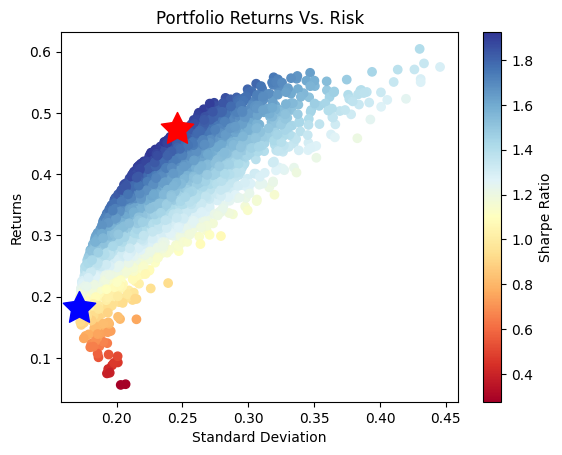

In [16]:
# This is so I can see the plot inside of my Jupyter Notebook.
%matplotlib inline

# Plot the data on a Scatter plot.
plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Plot the Max Sharpe Ratio, using a `Red Star`.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=(5, 1, 0),
    color='r',
    s=600
)

# Plot the Min Volatility, using a `Blue Star`.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker=(5, 1, 0),
    color='b',
    s=600
)

# Finally, show the plot.
plt.show()


Our Optimization Implementation

In [17]:
def get_metrics(weights: list) -> np.array:
    """
    ### Overview:
    ----
    With a given set of weights, return the portfolio returns,
    the portfolio volatility, and the portfolio sharpe ratio.

    ### Arguments:
    ----
    weights (list): An array of portfolio weights.

    ### Returns:
    ----
    (np.array): An array containg return value, a volatility value,
        and a sharpe ratio.
    """

    # Convert to a Numpy Array.
    weights = np.array(weights)

    # Calculate the returns, remember to annualize them (252).
    ret = np.sum(log_return.mean() * weights) * 252

    # Calculate the volatility, remember to annualize them (252).
    vol = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio.
    sr = ret / vol

    return np.array([ret, vol, sr])

def grab_negative_sharpe(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[2] - 1

def grab_volatility(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:
    """Ensure the allocations of the "weights", sums to 1 (100%)

    ### Arguments:
    ----
    weights (list): The weights we want to check to see
        if they sum to 1.

    ### Returns:
    ----
    float: The different between 1 and the sum of the weights.
    """
    return np.sum(weights) - 1

In [18]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the operation to minimize the risk.
optimized_sharpe = sci_opt.minimize(
    grab_negative_sharpe, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)


OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.8936169384103293
       x: [ 1.000e+00  0.000e+00  0.000e+00  0.000e+00]
     nit: 3
     jac: [-0.000e+00  2.308e+00  1.156e+00  2.913e+00]
    nfev: 15
    njev: 3
--------------------------------------------------------------------------------


In [19]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_sharpe.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)



OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[1. 0. 0. 0.]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.02277516 0.21408637 0.10638306]
--------------------------------------------------------------------------------


In [20]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the operation to minimize the risk.
optimized_volatility = sci_opt.minimize(
    grab_volatility, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED VOLATILITY RATIO:')
print('-'*80)
print(optimized_volatility)
print('-'*80)



OPTIMIZED VOLATILITY RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.17166568915545158
       x: [ 3.947e-01  2.455e-02  5.594e-01  2.139e-02]
     nit: 9
     jac: [ 1.716e-01  1.717e-01  1.717e-01  1.718e-01]
    nfev: 45
    njev: 9
--------------------------------------------------------------------------------


In [21]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_volatility.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_volatility.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)



OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[0.39465326 0.0245454  0.55941316 0.02138819]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.17858817 0.17166569 1.04032539]
--------------------------------------------------------------------------------


This is my custom NAG optimization approach

In [22]:
def optimize_weights_nesterov(log_return, initial_weights, num_iterations=1000, lr=0.01, gamma=0.9):
    weights = np.array(initial_weights)
    velocity = np.zeros_like(weights)
    metrics = {'sharpe_ratios': []}

    for i in range(num_iterations):
        lookahead_weights = weights + gamma * velocity
        current_sharpe = grab_negative_sharpe(lookahead_weights)

        # Estimating the gradient through a simple finite difference method
        grad = np.zeros_like(weights)
        for j in range(len(weights)):
            perturbed_weights = np.array(lookahead_weights)
            perturbed_weights[j] += 0.0001
            grad[j] = (grab_negative_sharpe(perturbed_weights) - current_sharpe) / 0.0001
        
        # Nesterov update
        velocity = gamma * velocity + lr * grad
        weights -= velocity

        # Apply constraints: Normalize and ensure they're within [0, 1]
        weights = np.clip(weights, 0, 1)
        weights /= np.sum(weights)  # Normalize to ensure sum to 1

        # Calculate and record the Sharpe ratio for analysis
        metrics['sharpe_ratios'].append(-grab_negative_sharpe(weights))  # Store positive value for analysis

    return weights, metrics


In [23]:
initial_weights = [0.25, 0.25, 0.25, 0.25]  # Example initial weights
optimized_weights, optimization_metrics = optimize_weights_nesterov(
    log_return,
    initial_weights,
    num_iterations=1000,
    lr=0.01,
    gamma=0.9
)

Plottiong the results

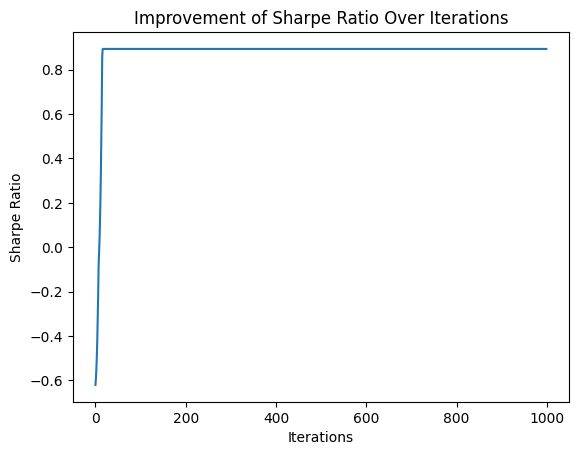

In [24]:
import matplotlib.pyplot as plt

plt.plot(optimization_metrics['sharpe_ratios'])
plt.title('Improvement of Sharpe Ratio Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Sharpe Ratio')
plt.show()


In [25]:
# Print the Optimized Weights
print('')
print('=' * 80)
print('OPTIMIZED WEIGHTS:')
print('-' * 80)
print(optimized_weights)
print('-' * 80)

# Print the Optimized Metrics
print('')
print('=' * 80)
print('OPTIMIZED METRICS:')
print('-' * 80)
print(f"Returns: {optimized_metrics[0]:.4f}")
print(f"Volatility: {optimized_metrics[1]:.4f}")
print(f"Sharpe Ratio: {optimized_metrics[2]:.4f}")
print('-' * 80)



OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[1. 0. 0. 0.]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
Returns: 0.1786
Volatility: 0.1717
Sharpe Ratio: 1.0403
--------------------------------------------------------------------------------
